**Introduction**


**Objectifs :** 


*   Mettre en équation la trajectoire de l’outil d’un bras articulé à 2 ddl 
*   Résoudre un problème inverse 
*   Utiliser scipy.optimize pour résoudre un système d’équations non linéaires
*   Programmer et comparer différentes méthodes pour résoudre le système d’équations non linéaires par minimisation du résidu du système

In [1]:
import numpy as np
from scipy import optimize 
import matplotlib.pyplot as plt
from Functions import *
from Gradient import  *
from Newton import *
from Graphics import *



C:\Users\khale\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


On considère le bras articulé à 2 degrés de liberté se comportant de deux segments L1 et L2. La positions de l'organe terminale P(x,y) est pilotée par les angles des articulations $theta1$ et $theta2$.
Notre objectif dans est de résoudre un probleme "inverse" nous permettant de trouver les coordonees articulaires $theta1$ et $theta2$ du robot qui permettent de générer une trajectoire $P[x(t),y(t)]$ donnée. 


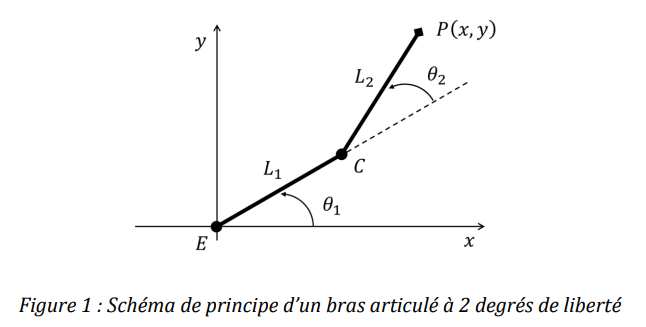

**Equation du modele geometrique directe :**

On definit $X$ le vecteur de positions de l'organe terminal P $X= F(\theta) $ 

$
F(\theta) = 
\begin{pmatrix}
L1 cos	\theta1 + L2 cos(	\theta1 + 	\theta2) \\
L1 sin	\theta1 + L2 sin(	\theta1 + 	\theta2)
\end{pmatrix}$

**Equation du résidu :**

On definit le résidu comme suit : $R(\theta)= F(\theta)-X$

$
R(\theta) = 
\begin{pmatrix}
L1 cos	\theta1 + L2 cos(	\theta1 + 	\theta2) - x\\
L1 sin	\theta1 + L2 sin(	\theta1 + 	\theta2) - y
\end{pmatrix}$

La fonction **Interp** permet de definir une trajectoire à suivre par le robot.Elle peut soit etre cubic sois etre linéaire.

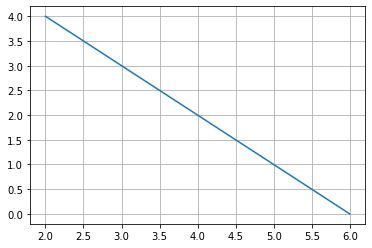

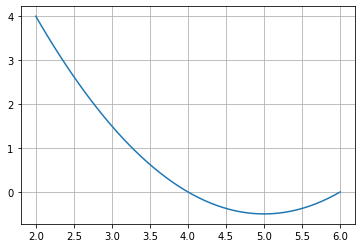

In [2]:
#Interpolation
Xf=[2,4]
Xi=[6,0]
N=50
x,y=Interp(Xi,Xf,N)
plt.figure()
plt.plot(x,y)
plt.grid()
# Pouur une trajectoire cubic
Xi = [2,4]
Xf = [6,0]
Xm = [3,1.5]
N=50
x,y=Interp(Xi,Xf,N,traj="Cube",Xm=Xm)
plt.figure()
plt.plot(x,y)
plt.grid()

In [3]:
L1=3
L2=3
X=np.array([2,1])
Params = [L1,L2,X]
init_config=[np.pi/4,np.pi/4]


 # Methode 1 : Root
print("Methode Root : ")
rt=optimize.root(R, [np.pi/4,np.pi/4],args = Params, jac=False)
#print(rt.success)
if rt.success==True:
    print(f"Les angles optimaux = {rt.x} \nLe point (X,Y) ={F(L1,L2,rt.x[0],rt.x[1])}")
    
else:
    print("Non reachable point")


Methode Root : 
Les angles optimaux = [-0.72525547  2.37780616] 
Le point (X,Y) =[2. 1.]


In [4]:
min_R_norm=optimize.minimize(R_norm,[np.pi/4,np.pi/4],args = Params)

print("Methode Minimize : ")
print(f"les angles optimaux ={min_R_norm.x} \nLe point (X,Y) ={F(L1,L2,min_R_norm.x[0],min_R_norm.x[1])}")


Methode Minimize : 
les angles optimaux =[-0.72525552  2.37780607] 
Le point (X,Y) =[2.00000032 0.99999992]


[0.38512498 1.44638267]
Methode du gradient a pas fixe : 
les angles optimaux = [0.38512498 1.44638267] 
Le point (X,Y) = [2.00695076 4.0256455 ]
True


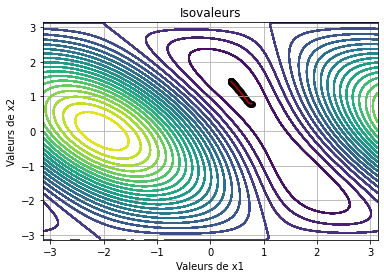

In [7]:
#Gradient a pas Fixe
aplha_init = 0.01

resultat , tr = GradienDecent(init_config,aplha_init,Params,10e-4,100) 
print(resultat)
print("Methode du gradient a pas fixe : ")
print(f"les angles optimaux = {resultat} \nLe point (X,Y) = {F(L1,L2,resultat[0],resultat[1])}")
print(tr)


C:\Users\khale\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

<Figure size 432x288 with 0 Axes>

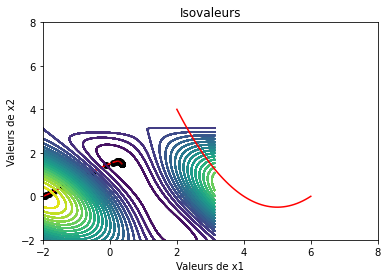

In [6]:
q = [-2,0] 

fig = plt.figure()
for i in  range(N): 
    X=[x[i],y[i]]
    Params[2] = X
    rt=optimize.root(R,q,args=Params, jac=False)
    rt = GradienDecent(q,aplha_init,Params,10e-4,100) 
    plt.plot(x,y,'r', label = 'droite')
    animate(rt,Params)
    q = rt